In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')

In [2]:
apr = pd.read_csv("data/uber-raw-data-apr14.csv")
may = pd.read_csv("data/uber-raw-data-may14.csv")
jun = pd.read_csv("data/uber-raw-data-jun14.csv")
jul = pd.read_csv("data/uber-raw-data-jul14.csv")
aug = pd.read_csv("data/uber-raw-data-aug14.csv")
sep = pd.read_csv("data/uber-raw-data-sep14.csv")

In [3]:
df = pd.concat([apr, may, jun, jul, aug, sep])

In [4]:
df.head()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4534327 entries, 0 to 1028135
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Date/Time  object 
 1   Lat        float64
 2   Lon        float64
 3   Base       object 
dtypes: float64(2), object(2)
memory usage: 173.0+ MB


In [6]:
df["Date/Time"] = pd.to_datetime(df["Date/Time"])
df["Date"] = pd.to_datetime(df["Date/Time"].dt.date)
df["Day_Num"] = df["Date"].dt.weekday.astype("object")
df["Week"] = pd.to_timedelta(df["Date"].dt.weekday, unit = "D")
df["Week"] = df["Date"] - df["Week"]
df["Month"] = pd.to_datetime(df["Date"].dt.strftime('%Y-%m-01'))
df["Month_Num"] = df["Date"].dt.month.astype("object")
df["Year"] = pd.to_datetime(df["Date"].dt.strftime('%Y-01-01'))
df["Hour"] = df["Date/Time"].dt.hour.astype("object")

In [7]:
df = df[["Date/Time", "Hour", "Date", "Day_Num", "Week", "Month", "Month_Num", "Year", "Lat", "Lon", "Base"]]

In [8]:
df["Order"] = 1

In [9]:
def ma_calculate(data, window = 1, min_periods = 1, thresholds = 2):
    mean = pd.DataFrame(data.rolling(window = window, min_periods = min_periods).mean())
    std = pd.DataFrame(data.rolling(window = window, min_periods = min_periods).std())
    upper_band= mean + thresholds * std
    lower_band= mean - thresholds * std
    anomaly_index = np.where((data > upper_band) | (data < lower_band))[0]
    return mean, std, upper_band, lower_band, anomaly_index

In [10]:
data_graph = pd.DataFrame(df.groupby("Week").sum()["Order"])
mean, std, upper_band, lower_band, anomaly_index = ma_calculate(data_graph, window = 7)

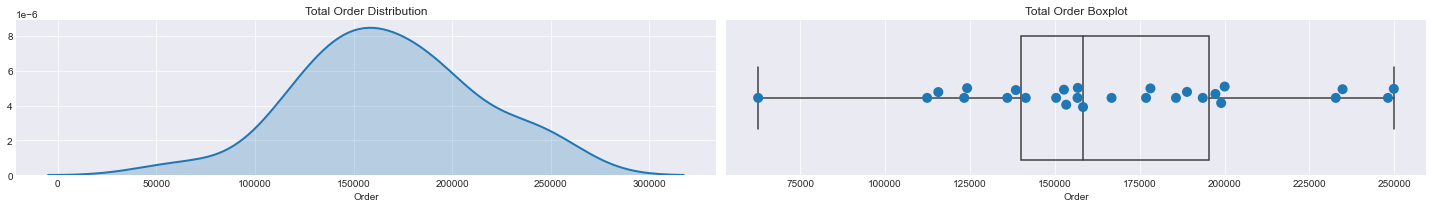

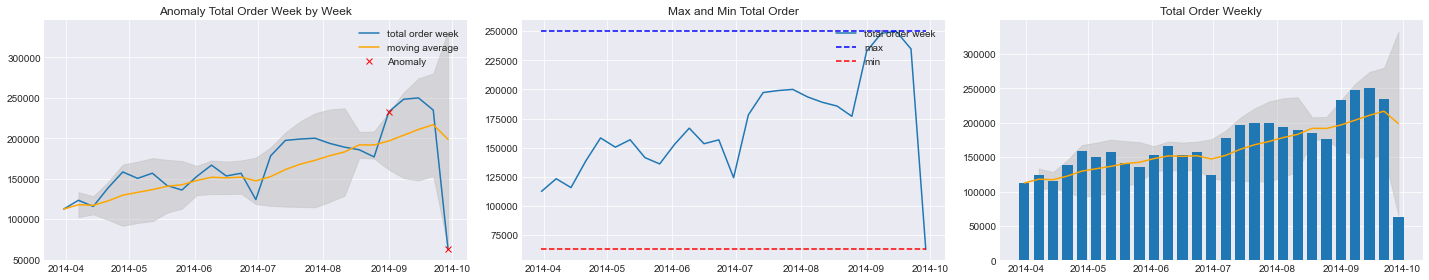

In [11]:
fig, ax = plt.subplots(1, 2, figsize = (20, 3))
sns.distplot(data_graph["Order"], hist = False, kde_kws = {'shade': True, 'linewidth': 2}, ax = ax[0])
sns.boxplot(data_graph["Order"], fliersize = 3, boxprops={'facecolor':'None'}, ax = ax[1])
sns.swarmplot(data_graph["Order"], size = 10, ax = ax[1])
ax[0].set_title("Total Order Distribution")
ax[1].set_title("Total Order Boxplot")
plt.tight_layout()
plt.show()
fig.savefig('data_uber_1.png')

fig, ax = plt.subplots(1, 3, figsize = (20, 4))
ax[0].plot(data_graph.index, data_graph["Order"], label = "total order week")
ax[0].plot(mean.index, mean["Order"], color = "orange", label = "moving average")
ax[0].fill_between(x = mean.index, y1 = lower_band["Order"], y2 = upper_band["Order"], color = "silver", alpha = 0.5)
ax[0].plot(data_graph.index[anomaly_index], data_graph.iloc[anomaly_index], "x", color="red", label="Anomaly")
ax[1].plot(data_graph.index, data_graph["Order"], label = "total order week")
ax[1].plot(data_graph.index, [data_graph["Order"].max()] * len(data_graph.index), color = "blue", ls = "--", label = "max")
ax[1].plot(data_graph.index, [data_graph["Order"].min()] * len(data_graph.index), color = "red", ls = "--", label = "min")
ax[2].bar(x = data_graph.index, height = data_graph["Order"], width = 5, label = "total order week")
ax[2].plot(mean.index, mean["Order"], color = "orange", label = "moving average")
ax[2].fill_between(x = mean.index, y1 = lower_band["Order"], y2 = upper_band["Order"], color = "silver", alpha = 0.5)
ax[0].set_title("Anomaly Total Order Week by Week")
ax[1].set_title("Max and Min Total Order")
ax[2].set_title("Total Order Weekly")
ax[0].legend()
ax[1].legend(loc = 1)
plt.tight_layout()
plt.show()
fig.savefig('data_uber_2.png')

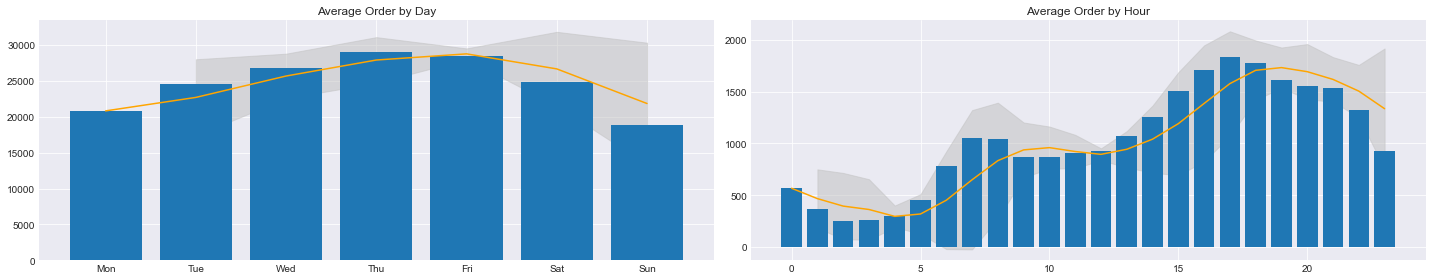

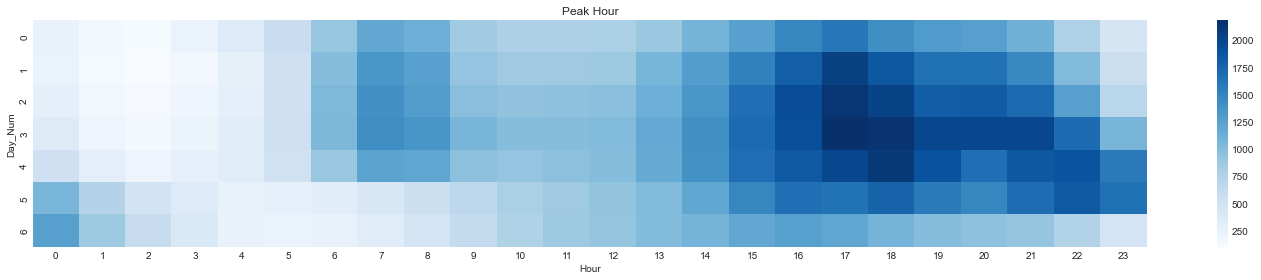

In [12]:
fig, ax = plt.subplots(1, 2, figsize = (20, 4))

data_graph = pd.DataFrame(df.groupby(["Date", "Day_Num"]).sum().reset_index())
data_graph = pd.DataFrame(data_graph.groupby("Day_Num").mean()["Order"])
mean, std, upper_band, lower_band, anomaly_index = ma_calculate(data_graph, window = 2)
ax[0].bar(x = data_graph.index, height = data_graph["Order"], label = "total order date")
ax[0].plot(mean.index, mean["Order"], color = "orange", label = "moving average")
ax[0].fill_between(x = mean.index, y1 = lower_band["Order"], y2 = upper_band["Order"], color = "silver", alpha = 0.5)
ax[0].set_title("Average Order by Day")
plt.setp(ax[0], xticks = [0, 1, 2, 3, 4, 5, 6],
         xticklabels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])

data_graph = pd.DataFrame(df.groupby(["Date", "Hour"]).sum().reset_index())
data_graph = pd.DataFrame(data_graph.groupby("Hour").mean()["Order"])
mean, std, upper_band, lower_band, anomaly_index = ma_calculate(data_graph, window = 4)
ax[1].bar(x = data_graph.index, height = data_graph["Order"], label = "total order date")
ax[1].plot(mean.index, mean["Order"], color = "orange", label = "moving average")
ax[1].fill_between(x = mean.index, y1 = lower_band["Order"], y2 = upper_band["Order"], color = "silver", alpha = 0.5)
ax[1].set_title("Average Order by Hour")

plt.tight_layout()
plt.show()

plt.figure(figsize = (20, 4))
data_graph = df.groupby(["Date", "Day_Num", "Hour"]).sum().reset_index()
data_graph = data_graph.groupby(["Day_Num", "Hour"]).mean()["Order"].reset_index()
sns.heatmap(data_graph.pivot_table(values = "Order", index = "Day_Num", columns = "Hour"), cmap = "Blues")
plt.title("Peak Hour")
plt.tight_layout()
plt.show()

In [13]:
data_graph = df.groupby(["Base", "Month_Num"]).sum().reset_index()

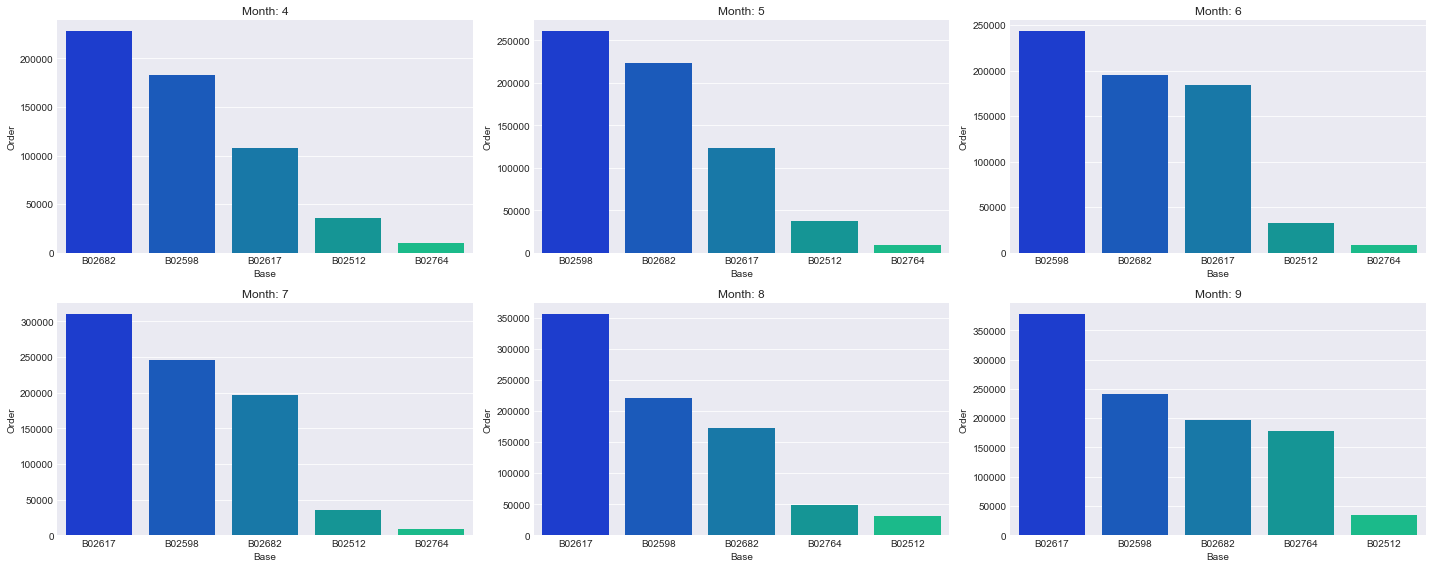

In [14]:
fig, ax = plt.subplots(2, 3, figsize = (20, 8))
for row in range(2):
    for col in range(3):
        sns.barplot(x = "Base", y = "Order",
                    data = data_graph[data_graph["Month_Num"] == 4 + (row * 3 + col)].sort_values("Order", ascending = False),
                    palette = "winter", ax = ax[row, col])
        ax[row, col].set_title("Month: " + str(4 + (row * 3 + col)))
plt.tight_layout()
plt.show()

In [15]:
# plt.figure(figsize = (15, 10))
# sns.scatterplot(x = "Lon", y = "Lat", hue = "Base", data = df, alpha = 0.5)
# plt.tight_layout()
# plt.show()